In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from itertools import product
import random
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [28]:
# training dataset loading
Training_csv_file_path = './data/TrainingSet/mRNA_sublocation_TrainingSet_NC-BERTdata.csv'
Training_data= pd.read_csv(Training_csv_file_path)
Training_data

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,label
0,0.008038,0.005472,0.007248,0.007894,0.007398,0.004448,0.000894,0.007232,0.009605,0.007154,...,-0.047920,-0.044799,0.009836,-0.027684,-0.060108,0.051503,0.074873,0.094912,0.142718,1
1,0.006421,0.004846,0.007124,0.006833,0.007555,0.005529,0.002641,0.006684,0.008229,0.006792,...,-0.063734,-0.007245,0.007870,-0.022348,-0.066921,0.064694,0.101658,0.116233,0.136837,1
2,0.012833,0.005971,0.006511,0.007626,0.007715,0.005825,0.001119,0.006599,0.007285,0.005525,...,-0.080484,-0.063357,0.037052,-0.023793,-0.052618,0.047666,0.088847,0.100192,0.156532,1
3,0.013917,0.006805,0.005778,0.013393,0.008006,0.004290,0.000706,0.007448,0.006812,0.002914,...,-0.044457,-0.043053,0.013077,-0.001783,-0.055099,0.052132,0.093488,0.079941,0.162534,1
4,0.017324,0.006722,0.007164,0.007420,0.007784,0.003431,0.001093,0.007214,0.006707,0.006244,...,-0.056244,-0.031527,0.027563,-0.006933,-0.035199,0.053570,0.106644,0.127546,0.129778,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4657,0.020823,0.006709,0.006760,0.009948,0.007638,0.003582,0.001047,0.007103,0.007427,0.004873,...,-0.071451,-0.064951,0.026554,-0.024152,-0.040399,0.054827,0.108673,0.107649,0.108352,0
4658,0.002121,0.007038,0.006064,0.003244,0.007038,0.005526,0.002388,0.005519,0.008397,0.006210,...,-0.069669,-0.118523,0.001044,-0.004282,-0.044469,0.064367,0.085585,0.090057,0.146606,0
4659,0.018389,0.005796,0.007591,0.005788,0.005100,0.006153,0.002046,0.007090,0.005993,0.006751,...,-0.073933,-0.074885,0.044387,-0.000744,-0.048722,-0.010145,0.098738,0.119175,0.117543,0
4660,0.001512,0.001544,0.005322,0.000000,0.003088,0.007880,0.001362,0.001574,0.003991,0.010899,...,-0.071051,-0.068419,-0.018095,0.009988,-0.081945,0.103257,-0.006743,0.098912,0.106491,0


In [29]:
# separate sequence features and labels
X_train = Training_data.drop(columns=['label']).values
y_train = Training_data['label'].values

In [30]:
# the training data and test data are standardized
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)

In [31]:
from sklearn.decomposition import PCA
import numpy as np
# Initialize PCA and set the number of principal components
pca = PCA(n_components=72)
# Fit PCA on the training data and transform the training data to its principal components
X_train = pca.fit_transform(X_train)


In [32]:
def evaluate_metrics(X, y, model, k=5, n_repeats=100, random_state=42):
    np.random.seed(random_state)
     # Initialize a dictionary to store the metrics.
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 score': []}
    # Repeat the cross-validation n_repeats times.
    for repeat in range(n_repeats):
        # Set up StratifiedKFold cross-validation.
        kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        # Iterate through each fold.
        for train_index, test_index in kfold.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            # Fit the model on the training data.
            model.fit(X_train, y_train)
            # Predict the labels for the testing data.
            y_pred = model.predict(X_test)
            metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['Precision'].append(precision_score(y_test, y_pred))
            metrics['Recall'].append(recall_score(y_test, y_pred))
            metrics['F1 score'].append(f1_score(y_test, y_pred))
    
    return metrics

#CatBoost

Accuracy Mean: 0.7001
Accuracy Standard Deviation: 0.0019
Precision Mean: 0.6842
Precision Standard Deviation: 0.0090
Recall Mean: 0.5779
Recall Standard Deviation: 0.0179
F1 score Mean: 0.6263
F1 score Standard Deviation: 0.0069


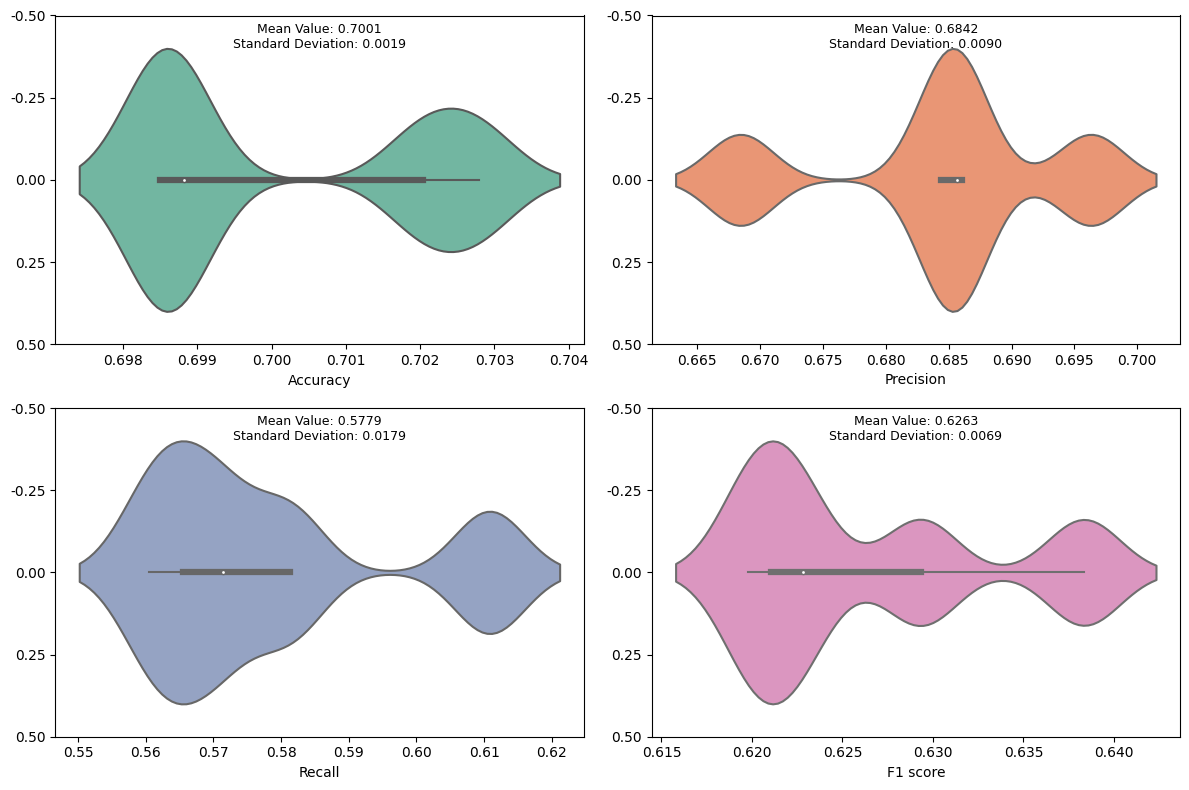

In [33]:
# Preparing the model
model = CatBoostClassifier(iterations=1000,learning_rate=0.08,depth=6,rsm=0.9,subsample=0.6,min_data_in_leaf=150, logging_level='Silent',early_stopping_rounds=50)
metrics = evaluate_metrics(X_train, y_train, model, random_state=42)
df = pd.DataFrame(metrics)

# Print the mean and standard deviation
for metric in df.columns:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}')
    print(f'{metric.capitalize()} Standard Deviation: {std_val:.4f}')

# Define a list of colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create a violin plot and display the mean and standard deviation on the plot
plt.figure(figsize=(12, 8))
for i, (metric, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=df, x=metric, color=color, ax=ax)
    
    # Calculate the mean and standard deviation
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    
    # Show the mean and standard deviation on the plot
    ax.annotate(f'Mean Value: {mean_val:.4f}\nStandard Deviation: {std_val:.4f}', 
                xy=(0.5, 0.935), 
                xycoords='axes fraction', 
                ha='center', 
                va='center', 
                fontsize=9, 
                bbox=dict(facecolor='none', edgecolor='none'))
    
    ax.set_xlabel(metric.capitalize())
    
    
    # Explicitly set the vertical axis scale and display the scale value
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
# Save as an HD image
plt.savefig('./result/CatBoost_Violinplot_Metrics.png', dpi=300)
plt.show()

#KNN

Accuracy Mean: 0.6802
Accuracy Standard Deviation: 0.0085
Precision Mean: 0.6972
Precision Standard Deviation: 0.0200
Recall Mean: 0.4694
Recall Standard Deviation: 0.0224
F1 score Mean: 0.5606
F1 score Standard Deviation: 0.0154


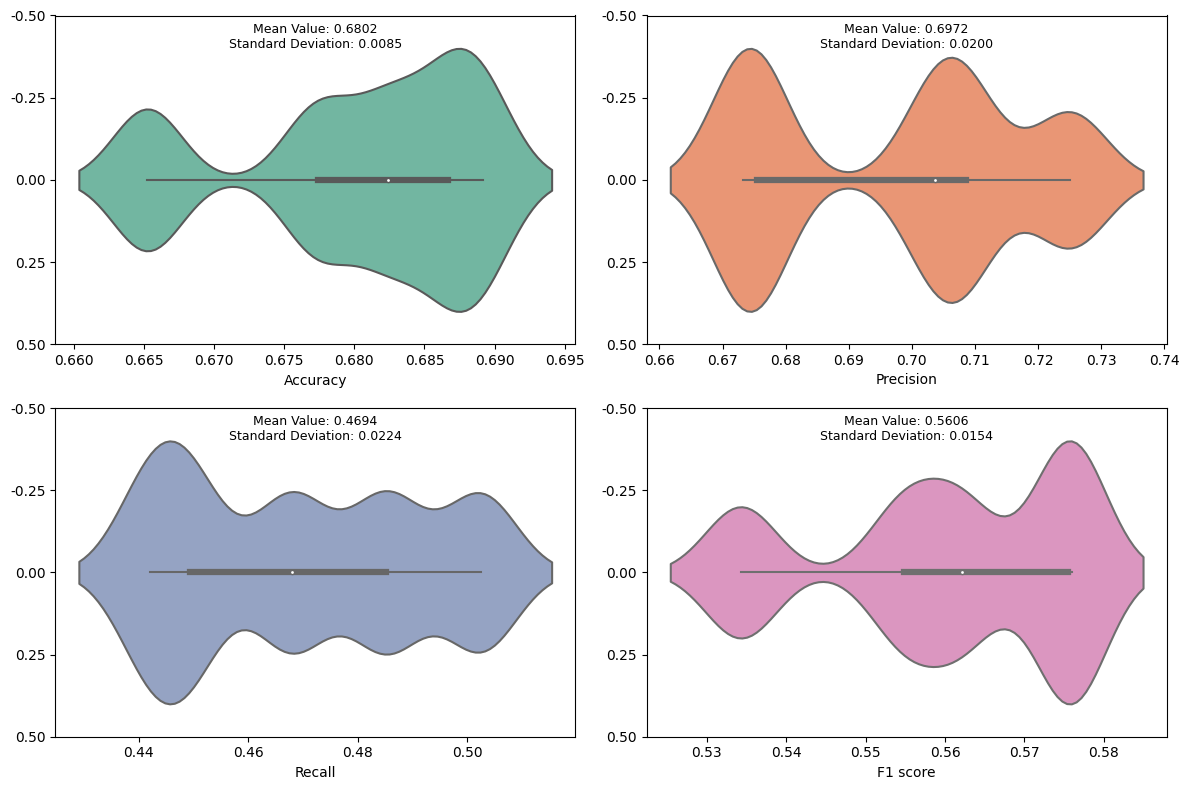

In [34]:
# Preparing the model
model = KNeighborsClassifier(n_neighbors=60, weights='distance', algorithm='ball_tree')
metrics = evaluate_metrics(X_train, y_train, model, random_state=42)
df = pd.DataFrame(metrics)

# Print the mean and standard deviation
for metric in df.columns:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}')
    print(f'{metric.capitalize()} Standard Deviation: {std_val:.4f}')

# Define a list of colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create a violin plot and display the mean and standard deviation on the plot
plt.figure(figsize=(12, 8))
for i, (metric, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=df, x=metric, color=color, ax=ax)
    
    # Calculate the mean and standard deviation
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    
    # Show the mean and standard deviation on the plot
    ax.annotate(f'Mean Value: {mean_val:.4f}\nStandard Deviation: {std_val:.4f}', 
                xy=(0.5, 0.935), 
                xycoords='axes fraction', 
                ha='center', 
                va='center', 
                fontsize=9, 
                bbox=dict(facecolor='none', edgecolor='none'))
    
    ax.set_xlabel(metric.capitalize())
    
    
    # Explicitly set the vertical axis scale and display the scale value
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
# Save as an HD image
plt.savefig('./result/KNN_Violinplot_Metrics.png', dpi=300)
plt.show()

#LR

Accuracy Mean: 0.6943
Accuracy Standard Deviation: 0.0179
Precision Mean: 0.6751
Precision Standard Deviation: 0.0232
Recall Mean: 0.5730
Recall Standard Deviation: 0.0289
F1 score Mean: 0.6197
F1 score Standard Deviation: 0.0252


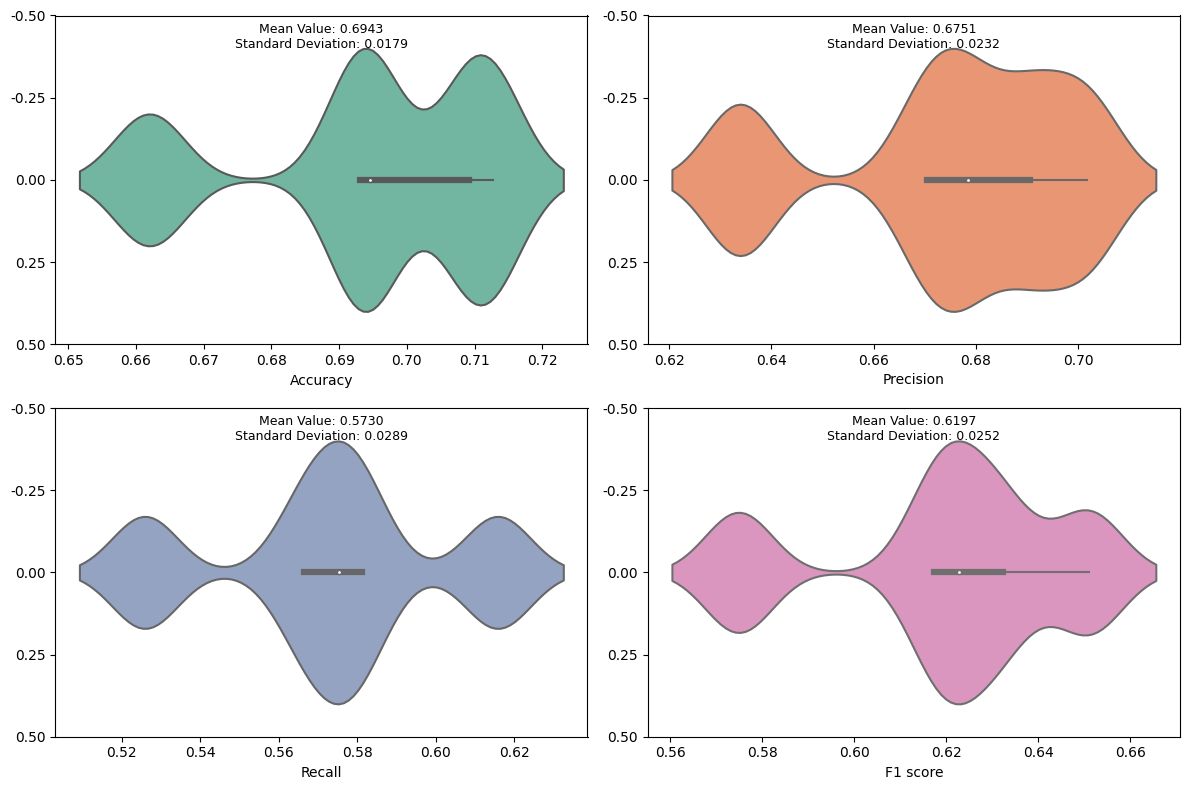

In [35]:
# Preparing the model
model = LogisticRegression(C=0.1,max_iter=20)
metrics = evaluate_metrics(X_train, y_train, model, random_state=42)
df = pd.DataFrame(metrics)

# Print the mean and standard deviation
for metric in df.columns:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}')
    print(f'{metric.capitalize()} Standard Deviation: {std_val:.4f}')

# Define a list of colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create a violin plot and display the mean and standard deviation on the plot
plt.figure(figsize=(12, 8))
for i, (metric, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=df, x=metric, color=color, ax=ax)
    
    # Calculate the mean and standard deviation
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    
    # Show the mean and standard deviation on the plot
    ax.annotate(f'Mean Value: {mean_val:.4f}\nStandard Deviation: {std_val:.4f}', 
                xy=(0.5, 0.935), 
                xycoords='axes fraction', 
                ha='center', 
                va='center', 
                fontsize=9, 
                bbox=dict(facecolor='none', edgecolor='none'))
    
    ax.set_xlabel(metric.capitalize())
   
    
    # Explicitly set the vertical axis scale and display the scale value
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
# Save as an HD image
plt.savefig('./result/LR_Violinplot_Metrics.png', dpi=300)
plt.show()

#RF

Accuracy Mean: 0.6799
Accuracy Standard Deviation: 0.0118
Precision Mean: 0.6713
Precision Standard Deviation: 0.0178
Recall Mean: 0.5177
Recall Standard Deviation: 0.0233
F1 score Mean: 0.5844
F1 score Standard Deviation: 0.0187


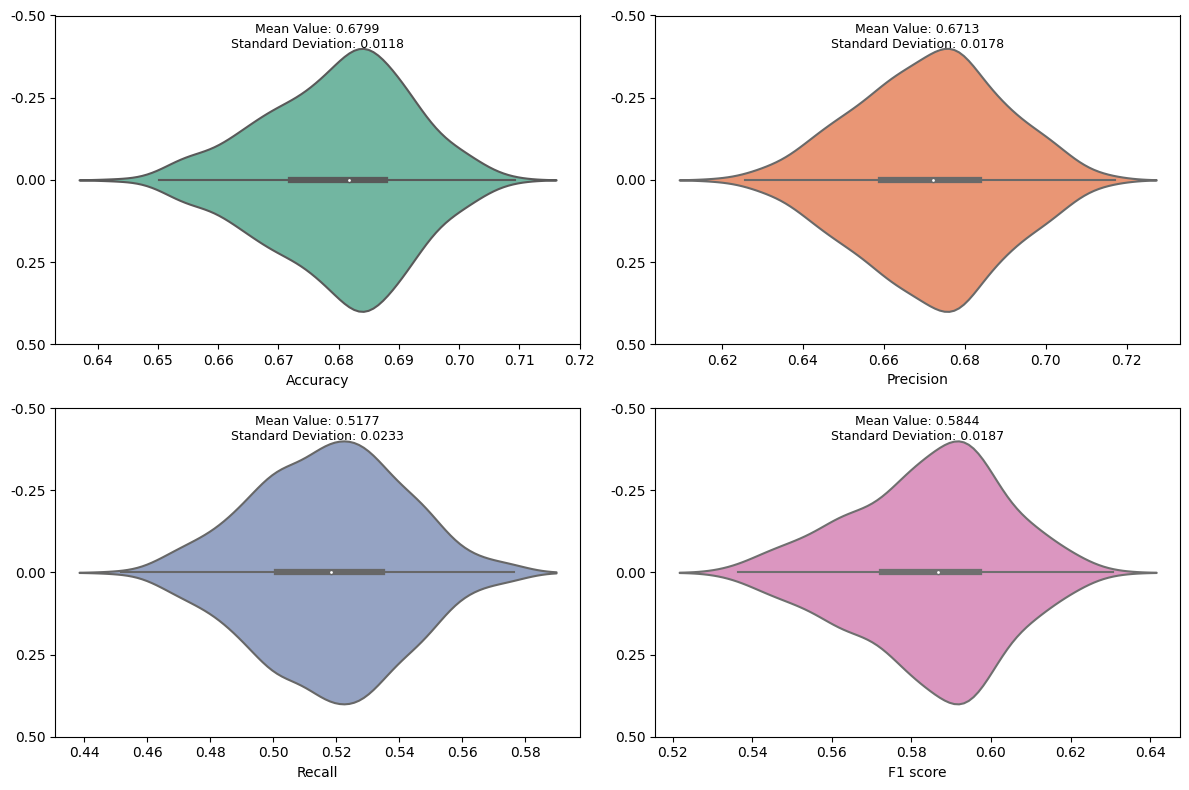

In [36]:
# Preparing the model
model = RandomForestClassifier(n_estimators=80,max_depth=20)
metrics = evaluate_metrics(X_train, y_train, model, random_state=42)
df = pd.DataFrame(metrics)

# Print the mean and standard deviation
for metric in df.columns:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}')
    print(f'{metric.capitalize()} Standard Deviation: {std_val:.4f}')

# Define a list of colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create a violin plot and display the mean and standard deviation on the plot
plt.figure(figsize=(12, 8))
for i, (metric, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=df, x=metric, color=color, ax=ax)
    
    # Calculate the mean and standard deviation
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    
    # Show the mean and standard deviation on the plot
    ax.annotate(f'Mean Value: {mean_val:.4f}\nStandard Deviation: {std_val:.4f}', 
                xy=(0.5, 0.935), 
                xycoords='axes fraction', 
                ha='center', 
                va='center', 
                fontsize=9, 
                bbox=dict(facecolor='none', edgecolor='none'))
    
    ax.set_xlabel(metric.capitalize())
    
    # Explicitly set the vertical axis scale and display the scale value
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
# Save as an HD image
plt.savefig('./result/RF_Violinplot_Metrics.png', dpi=300)
plt.show()

#SVM

Accuracy Mean: 0.6735
Accuracy Standard Deviation: 0.0071
Precision Mean: 0.6973
Precision Standard Deviation: 0.0068
Recall Mean: 0.4408
Recall Standard Deviation: 0.0230
F1 score Mean: 0.5398
F1 score Standard Deviation: 0.0178


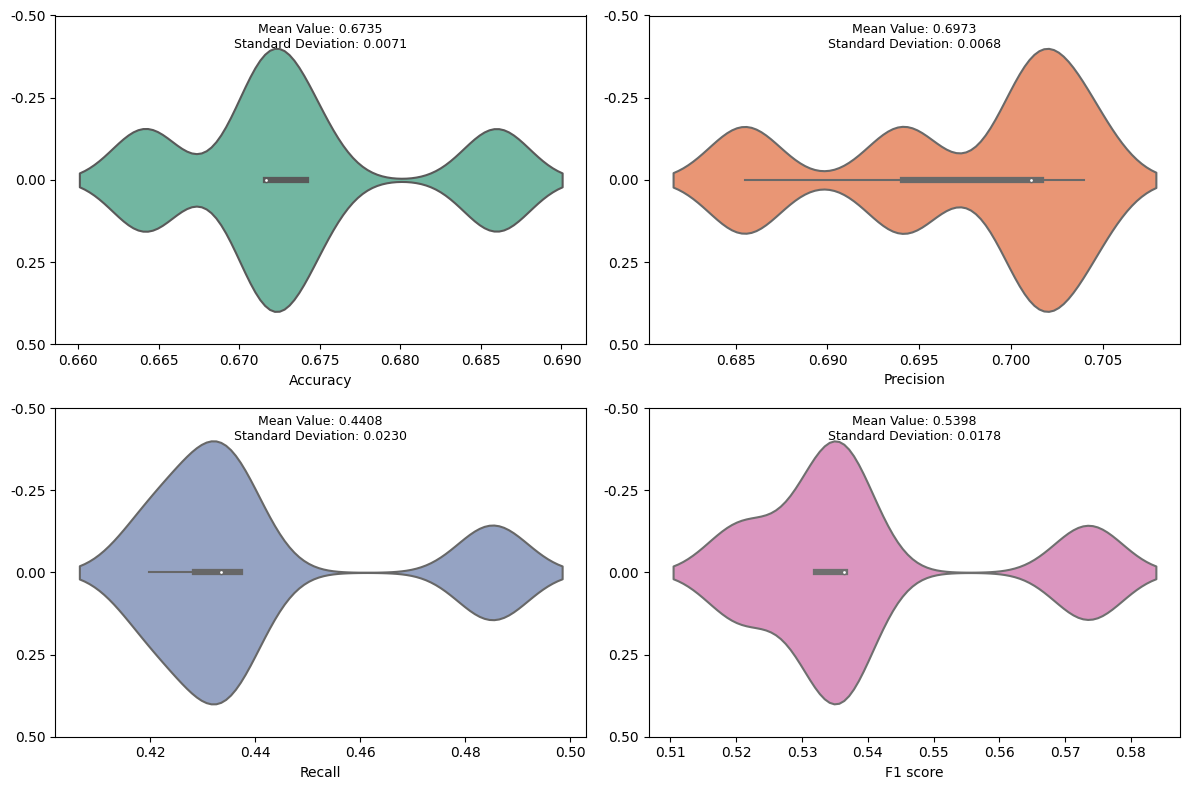

In [37]:
# Preparing the model
model = svm.SVC(kernel='rbf',C=1,gamma=0.01,degree=2,coef0=1)
metrics = evaluate_metrics(X_train, y_train, model, random_state=42)
df = pd.DataFrame(metrics)

# Print the mean and standard deviation
for metric in df.columns:
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    print(f'{metric.capitalize()} Mean: {mean_val:.4f}')
    print(f'{metric.capitalize()} Standard Deviation: {std_val:.4f}')

# Define a list of colors
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

# Create a violin plot and display the mean and standard deviation on the plot
plt.figure(figsize=(12, 8))
for i, (metric, color) in enumerate(zip(df.columns, colors), 1):
    ax = plt.subplot(2, 2, i)
    sns.violinplot(data=df, x=metric, color=color, ax=ax)
    
    # Calculate the mean and standard deviation
    mean_val = df[metric].mean()
    std_val = df[metric].std()
    
    # Show the mean and standard deviation on the plot
    ax.annotate(f'Mean Value: {mean_val:.4f}\nStandard Deviation: {std_val:.4f}', 
                xy=(0.5, 0.935), 
                xycoords='axes fraction', 
                ha='center', 
                va='center', 
                fontsize=9, 
                bbox=dict(facecolor='none', edgecolor='none'))
    
    ax.set_xlabel(metric.capitalize())
    
    
    # Explicitly set the vertical axis scale and display the scale value
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=4))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
# Save as an HD image
plt.savefig('./result/SVM_Violinplot_Metrics.png', dpi=300)
plt.show()